In [1]:
import pandas as pd
from pathlib import Path

train_path = Path("../data/processed/train.tsv")
test_path = Path("../data/processed/test.tsv")
metrics_summary_path = Path("../reports/metrics/metrics_summary.tsv")

df_train = pd.read_csv(train_path, sep="\t")
df_test = pd.read_csv(test_path, sep="\t")

metrics_summary = pd.read_csv(metrics_summary_path, sep="\t")
metrics_summary

,model,cv_accuracy_mean,cv_accuracy_std,cv_f1_mean,cv_f1_std,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,n_train,n_test
0,dummy_baseline,0.500219,0.000031,0.666861,0.000028,0.500188,0.500188,1.0000,0.666833,0.5,31986,7997
1,logreg_l2,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.0000,1.000000,1.0,31986,7997
2,linear_svm_calibrated,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.0000,1.000000,1.0,31986,7997
3,random_forest,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.0000,1.000000,1.0,31986,7997
4,extra_trees,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.0000,1.000000,1.0,31986,7997
5,gradient_boosting,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.0000,1.000000,1.0,31986,7997
6,xgboost,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.0000,1.000000,1.0,31986,7997
7,lightgbm,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.0000,1.000000,1.0,31986,7997
8,catboost,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.0000,1.000000,1.0,31986,7997
9,knn,0.999687,0.000198,0.999687,0.000198,0.999750,1.000000,0.9995,0.999750,1.0,31986,7997


In [7]:
import joblib
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
)

models_dir = Path("../models")

def load_model(name: str):
    return joblib.load(models_dir / name)

def evaluate_model(clf, X, y, model_name="(model)"):
    y_prob = clf.predict_proba(X)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    
    print(f"=== {model_name} ===")
    print(classification_report(y, y_pred, digits=4))
    print("ROC-AUC:", roc_auc_score(y, y_prob))
    print("Confusion matrix:\n", confusion_matrix(y, y_pred))

In [12]:
import pandas as pd
import numpy as np

# same logic as in hyperparam_search_top.py
def load_dataset(path: str):
    df = pd.read_csv(path, sep="\t")

    if "label" not in df.columns:
        raise ValueError("Expected a 'label' column in the dataset.")

    # numeric-only features
    numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
    feature_cols = [c for c in numeric_cols if c != "label"]

    X = df[feature_cols].to_numpy(dtype=float)
    y = df["label"].to_numpy(dtype=int)

    return X, y, feature_cols

# adjust the path if needed
test_path = "../data/processed/test.tsv"

X_test, y_test, feature_names = load_dataset(test_path)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("First 5 feature names:", feature_names[:5])

X_test shape: (7997, 25)
y_test shape: (7997,)
First 5 feature names: ['read_length', 'mean_base_quality', 'ref_start_1based', 'mapq', 'has_sa']


In [13]:
rf_tuned   = load_model("random_forest_tuned.joblib")
xgb_tuned  = load_model("xgboost_tuned.joblib")
lgbm_tuned = load_model("lightgbm_tuned.joblib")

evaluate_model(rf_tuned,   X_test, y_test, "RandomForest (tuned)")
evaluate_model(xgb_tuned,  X_test, y_test, "XGBoost (tuned)")
evaluate_model(lgbm_tuned, X_test, y_test, "LightGBM (tuned)")

=== RandomForest (tuned) ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3997
           1     1.0000    1.0000    1.0000      4000

    accuracy                         1.0000      7997
   macro avg     1.0000    1.0000    1.0000      7997
weighted avg     1.0000    1.0000    1.0000      7997

ROC-AUC: 1.0
Confusion matrix:
 [[3997    0]
 [   0 4000]]
=== XGBoost (tuned) ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3997
           1     1.0000    1.0000    1.0000      4000

    accuracy                         1.0000      7997
   macro avg     1.0000    1.0000    1.0000      7997
weighted avg     1.0000    1.0000    1.0000      7997

ROC-AUC: 1.0
Confusion matrix:
 [[3997    0]
 [   0 4000]]
=== LightGBM (tuned) ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3997
           1     1.0000    1.0000    1.00

In [14]:
import numpy as np
import pandas as pd

def feature_importance_table(model, feature_names, top_n=20):
    """
    Works for tree-based models that have .feature_importances_
    (RandomForest, XGBoost, LightGBM, ExtraTrees, etc.)
    """
    importances = model.feature_importances_
    df_imp = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False)

    return df_imp.head(top_n)

rf_imp  = feature_importance_table(rf_tuned,  feature_names)
xgb_imp = feature_importance_table(xgb_tuned, feature_names)
lgb_imp = feature_importance_table(lgbm_tuned, feature_names)

print("=== RandomForest top features ===")
display(rf_imp)

print("=== XGBoost top features ===")
display(xgb_imp)

print("=== LightGBM top features ===")
display(lgb_imp)

=== RandomForest top features ===


,feature,importance
1,mean_base_quality,0.688214
19,total_clipped_bases,0.098878
4,has_sa,0.028048
9,sa_max_delta_pos,0.024185
18,softclip_right,0.019844
6,num_segments,0.018465
17,softclip_left,0.018168
10,sa_mean_delta_pos,0.017493
14,sa_mean_mapq,0.015970
11,sa_same_strand_count,0.015727


=== XGBoost top features ===


,feature,importance
1,mean_base_quality,1.0
0,read_length,0.0
13,sa_max_mapq,0.0
23,microhomology_length,0.0
22,kmer_js_divergence,0.0
21,kmer_cosine_diff,0.0
20,breakpoint_read_pos,0.0
19,total_clipped_bases,0.0
18,softclip_right,0.0
17,softclip_left,0.0


=== LightGBM top features ===


,feature,importance
2,ref_start_1based,380
1,mean_base_quality,159
8,sa_min_delta_pos,58
21,kmer_cosine_diff,41
19,total_clipped_bases,18
17,softclip_left,14
13,sa_max_mapq,10
3,mapq,6
22,kmer_js_divergence,6
18,softclip_right,6


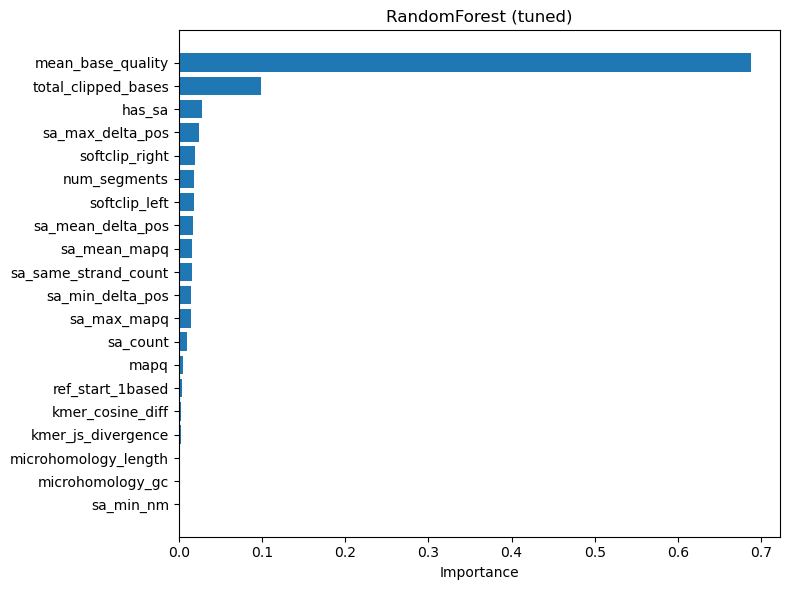

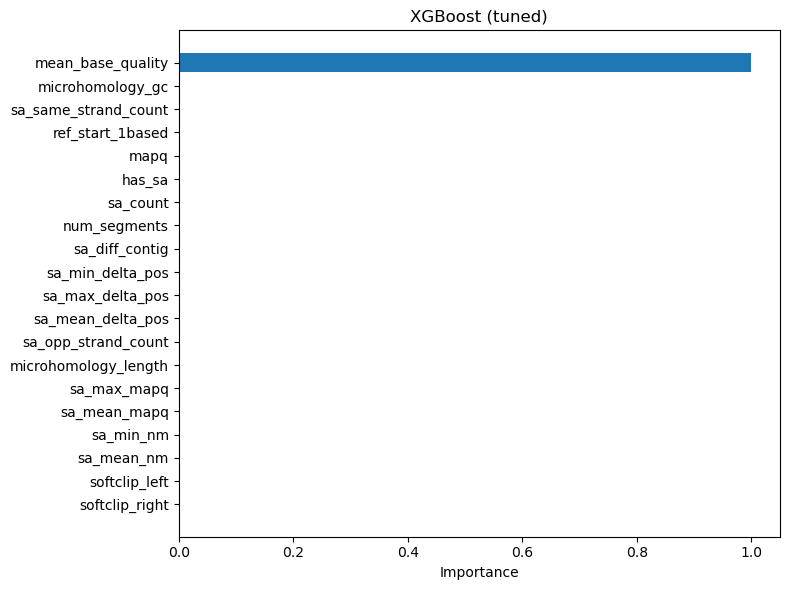

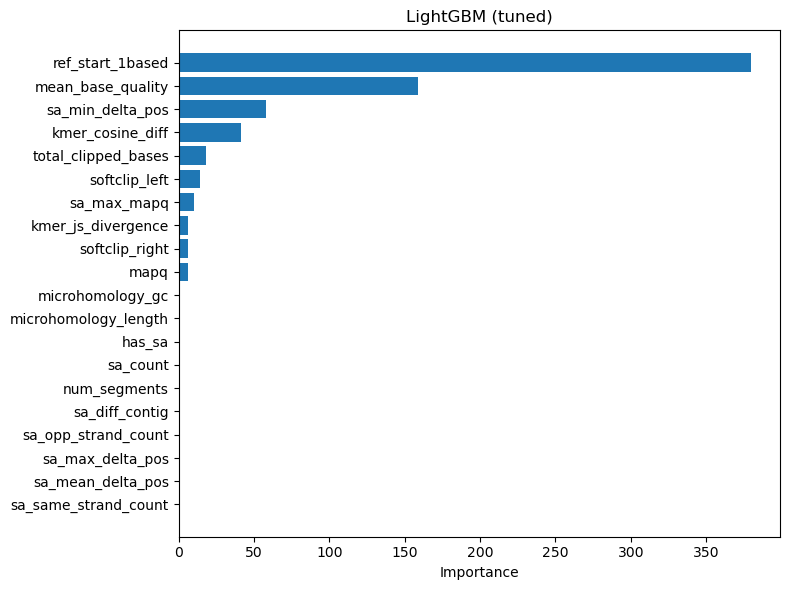

In [15]:
import matplotlib.pyplot as plt

def plot_feature_importances(model, feature_names, top_n=20, title="Feature importances"):
    importances = model.feature_importances_
    idx = np.argsort(importances)[::-1][:top_n]
    top_feats = [feature_names[i] for i in idx]
    top_vals  = importances[idx]

    plt.figure(figsize=(8, 6))
    plt.barh(range(len(top_feats)), top_vals)
    plt.yticks(range(len(top_feats)), top_feats)
    plt.gca().invert_yaxis()
    plt.xlabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_feature_importances(rf_tuned,  feature_names, title="RandomForest (tuned)")
plot_feature_importances(xgb_tuned, feature_names, title="XGBoost (tuned)")
plot_feature_importances(lgbm_tuned, feature_names, title="LightGBM (tuned)")

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Adjust these if needed
baseline_path = Path("../reports/metrics_noq/metrics_summary.tsv")
tuned_path    = Path("../reports/hparam_tuning_noq/tuned_models_summary.tsv")

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Adjust these if needed
baseline_path = Path("../reports/metrics_noq/metrics_summary.tsv")
tuned_path    = Path("../reports/hparam_tuning_noq/tuned_models_summary.tsv")

# 1) Load baseline metrics from train_all_models (no-quality features)
baseline = pd.read_csv(baseline_path, sep="\t")

# 2) Load tuned summary from hyperparam_search_top
tuned = pd.read_csv(tuned_path, sep="\t")

display(baseline.head())
display(tuned.head())

# --- Rename the 'model' columns so they don't collide ---
baseline = baseline.rename(columns={"model": "model_name_base"})
tuned    = tuned.rename(columns={"model": "model_name_tuned"})

# 3) Build a common model ID (without the "_tuned" suffix)
baseline["model_id"] = baseline["model_name_base"]
tuned["model_id"]    = tuned["model_name_tuned"].str.replace("_tuned$", "", regex=True)

# 4) Merge on model_id
merged = pd.merge(
    baseline,
    tuned,
    on="model_id",
    how="inner",
    suffixes=("_base", "_tuned"),
)

# For convenience, keep a pretty model_name column
merged["model_name"] = merged["model_id"]

# Sort by tuned F1 descending
merged = merged.sort_values("test_f1_tuned", ascending=False).reset_index(drop=True)

display(merged[[
    "model_name",
    "test_f1_base", "test_roc_auc_base",
    "test_f1_tuned", "test_roc_auc_tuned"
]])

,model,cv_accuracy_mean,cv_accuracy_std,cv_f1_mean,cv_f1_std,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,n_train,n_test
0,dummy_baseline,0.500219,0.000031,0.666861,0.000028,0.500188,0.500188,1.00000,0.666833,0.500000,31986,7997
1,logreg_l2,0.792128,0.007950,0.749644,0.010660,0.794923,0.942611,0.62825,0.753975,0.828504,31986,7997
2,linear_svm_calibrated,0.792159,0.007961,0.749859,0.010691,0.794673,0.941573,0.62850,0.753823,0.828783,31986,7997
3,random_forest,0.796693,0.005986,0.766246,0.007178,0.801050,0.904059,0.67375,0.772096,0.846966,31986,7997
4,extra_trees,0.794754,0.006380,0.761974,0.007377,0.797799,0.907629,0.66325,0.766431,0.834252,31986,7997


,model,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,logreg_l2_tuned,0.794048,0.942793,0.62625,0.752591,0.826313
1,linear_svm_calibrated_tuned,0.793673,0.941729,0.62625,0.752252,0.825846
2,random_forest_tuned,0.806803,0.918799,0.67325,0.777088,0.852546
3,extra_trees_tuned,0.806052,0.918919,0.67150,0.775964,0.850915
4,gradient_boosting_tuned,0.810429,0.931250,0.67050,0.779651,0.853049


,model_name,test_f1_base,test_roc_auc_base,test_f1_tuned,test_roc_auc_tuned
0,gradient_boosting,0.776801,0.848525,0.779651,0.853049
1,catboost,0.777290,0.849048,0.779646,0.853743
2,bagging_trees,0.775569,0.850347,0.777987,0.853984
3,random_forest,0.772096,0.846966,0.777088,0.852546
4,lightgbm,0.775950,0.850709,0.776713,0.852386
5,extra_trees,0.766431,0.834252,0.775964,0.850915
6,xgboost,0.776739,0.849498,0.773995,0.848978
7,mlp,0.754378,0.828501,0.755938,0.826161
8,logreg_l2,0.753975,0.828504,0.752591,0.826313
9,linear_svm_calibrated,0.753823,0.828783,0.752252,0.825846


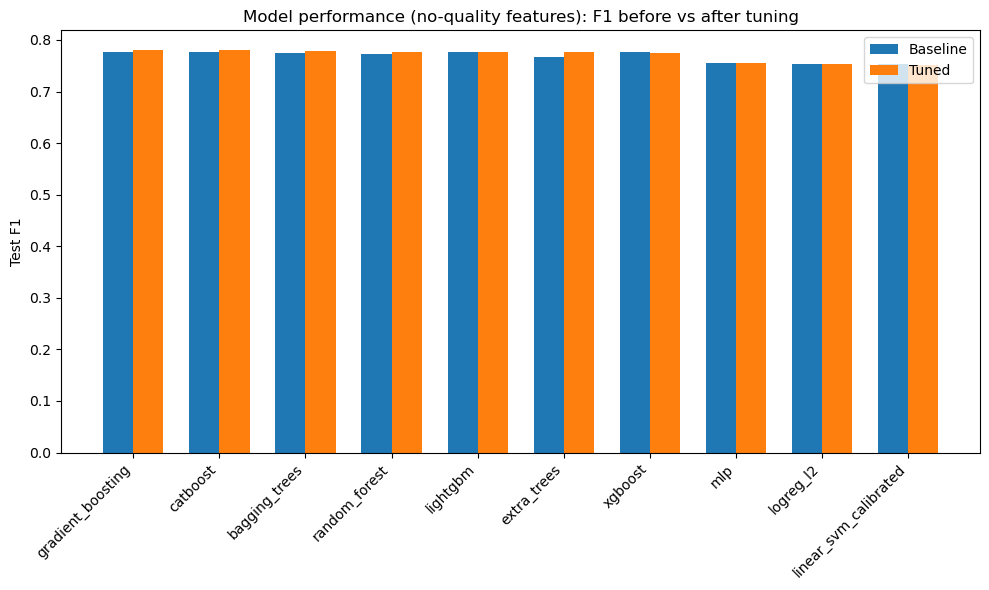

In [45]:
plt.figure(figsize=(10, 6))

x = range(len(merged))
width = 0.35

plt.bar(
    [i - width/2 for i in x],
    merged["test_f1_base"],
    width=width,
    label="Baseline"
)

plt.bar(
    [i + width/2 for i in x],
    merged["test_f1_tuned"],
    width=width,
    label="Tuned"
)

plt.xticks(x, merged["model_name"], rotation=45, ha="right")
plt.ylabel("Test F1")
plt.title("Model performance (no-quality features): F1 before vs after tuning")
plt.legend()
plt.tight_layout()
plt.show()

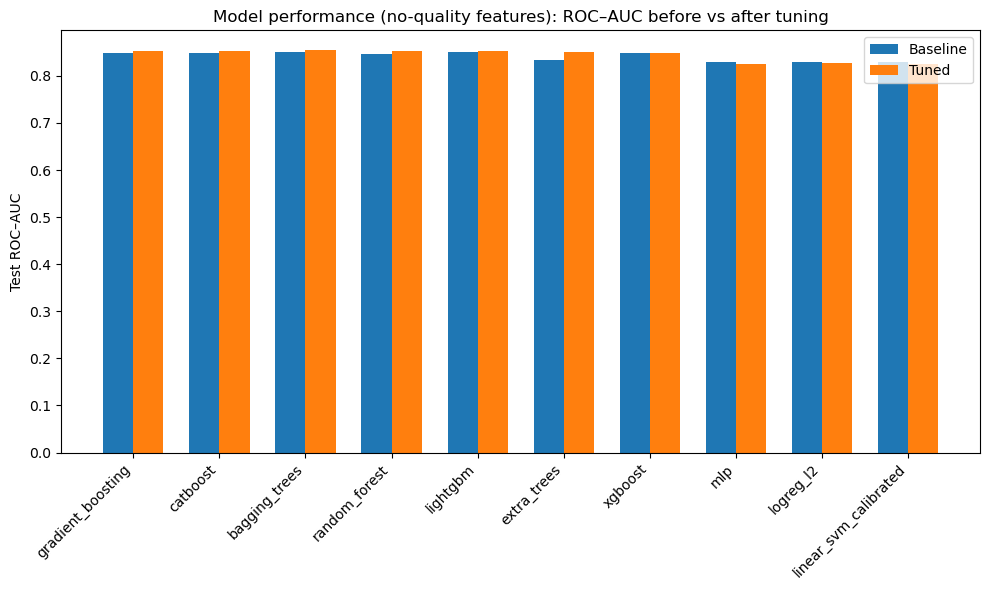

In [47]:
plt.figure(figsize=(10, 6))

x = range(len(merged))
width = 0.35

plt.bar(
    [i - width/2 for i in x],
    merged["test_roc_auc_base"],
    width=width,
    label="Baseline"
)

plt.bar(
    [i + width/2 for i in x],
    merged["test_roc_auc_tuned"],
    width=width,
    label="Tuned"
)

plt.xticks(x, merged["model_name"], rotation=45, ha="right")
plt.ylabel("Test ROC–AUC")
plt.title("Model performance (no-quality features): ROC–AUC before vs after tuning")
plt.legend()
plt.tight_layout()
plt.show()

Top 5 models by tuned F1 on test set:


,model_name,test_f1_tuned,test_roc_auc_tuned,test_f1_base,test_roc_auc_base
0,gradient_boosting,0.779651,0.853049,0.776801,0.848525
1,catboost,0.779646,0.853743,0.777290,0.849048
2,bagging_trees,0.777987,0.853984,0.775569,0.850347
3,random_forest,0.777088,0.852546,0.772096,0.846966
4,lightgbm,0.776713,0.852386,0.775950,0.850709


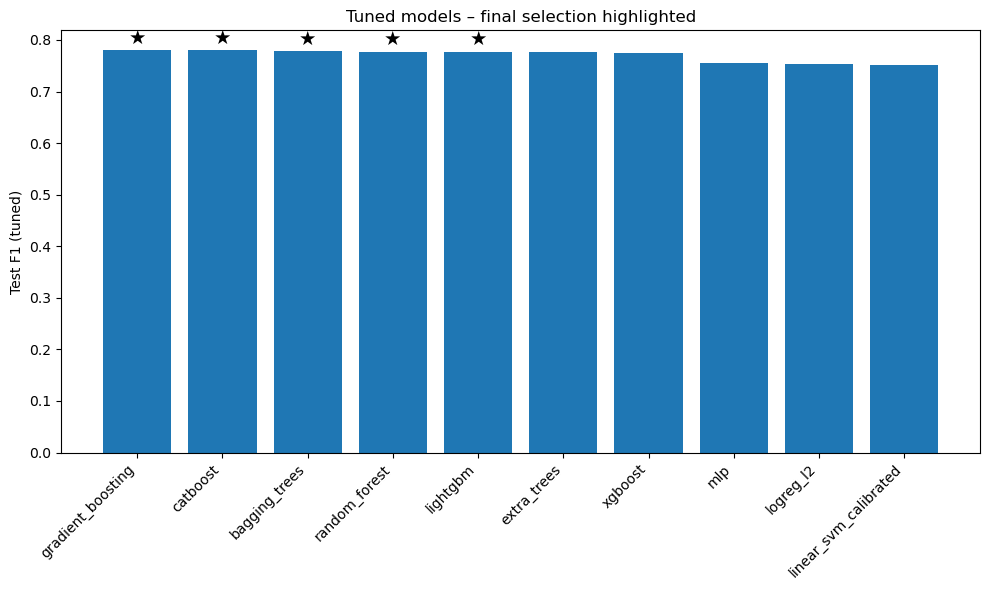

In [48]:
# How many final models you want to carry forward (change this as you like)
TOP_K = 5

# Sort by tuned F1 (desc) and choose top K
selected = merged.sort_values("test_f1_tuned", ascending=False).head(TOP_K)

print(f"Top {TOP_K} models by tuned F1 on test set:")
display(selected[[
    "model_name",
    "test_f1_tuned",
    "test_roc_auc_tuned",
    "test_f1_base",
    "test_roc_auc_base",
]])

selected_names = set(selected["model_name"].tolist())

# Plot tuned F1 with stars for selected models
plt.figure(figsize=(10, 6))
x = range(len(merged))

bars = plt.bar(x, merged["test_f1_tuned"])

plt.xticks(x, merged["model_name"], rotation=45, ha="right")
plt.ylabel("Test F1 (tuned)")
plt.title("Tuned models – final selection highlighted")

# Add a star above bars for selected models
for i, (name, f1) in enumerate(zip(merged["model_name"], merged["test_f1_tuned"])):
    if name in selected_names:
        plt.text(i, f1 + 0.005, "★", ha="center", va="bottom", fontsize=14)

plt.tight_layout()
plt.show()